<a href="https://colab.research.google.com/github/ThuyLTN/ThucHanhCDTGMT/blob/master/FaceRecognition_MiniChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   CHUYÊN ĐỀ THỊ GIÁC MÁY TÍNH
   
   Giảng viên: PGS.TS. Lê Đình Duy
   
   Học viên thực hiện: Lê Thị Ngọc Thúy
   
   >>>>># FACE RECOGNITION - MINI CHALLENGE





#1 - Giới thiệu
#1.1 - Bài toán
> - Bài toán nhận diện gương mặt ở lớp học, với mục tiêu xa là ứng dụng vào điểm danh cho lớp học chỉ với ảnh được chụp từ smartphone
> - Input: 1 ảnh chụp bằng smartphone.
> - Output: ảnh với bounding box gương mặt và gán label cho gương mặt đó
> - Dataset: ảnh các gương mặt được cắt ra từ ảnh chụp smartphone, được bổ sung từ nhiều học viên trong lớp. 
>>Mỗi học viên tạo thư mục ảnh với tên mình theo format (ví dụ: Lê Văn Anh --> ANHLV), bổ sung ảnh của mình vào thử mục

#1.2 - Khung bài làm
> - Phần 1. Giới thiệu
>> Giới thiệu bài toán và sơ lược khung bài làm
> - Phần 2. Chuẩn bị cho phần cài đặt
>> Gồm các bước kết nối drive và chuẩn bị thư viện
> - Phần 3. Cài đặt
>> Sơ lược về dataset, chi tiết các bước cài đặt bài toán, đánh giá kết quả cho bài làm

#2 - Chuẩn bị cho phần cài đặt
> -  Kết nối với google drive, cho phép truy cập dữ liệu và thực hành trên dữ liệu
> -  Cài đặt các thư viện cần thiết cho bài làm

In [1]:
# Kết nối với google drive
# Cho phép lấy dữ liệu ảnh từ drive, gồm FaceDB và ảnh test
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd drive
%cd My Drive
%cd ThucHanhCDTGMT

/content/drive
/content/drive/My Drive
/content/drive/My Drive/ThucHanhCDTGMT


In [3]:
# Cài đặt thư viện
# MTCNN cho phát hiện gương mặt (Face detection)
# MTCNN: https://github.com/ipazc/mtcnn
# face_recognition cho rút trích feature và tính sự khác nhau giữa các gương mặt (distance)
# face_recognition: https://github.com/ageitgey/face_recognition
# face_recognition: https://face-recognition.readthedocs.io/en/latest/face_recognition.html
!pip install mtcnn
!pip install face_recognition

     |████████████████████████████████| 2.3MB 2.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/85/81/65/6363fa5aafd7a155c896591e0c7c6e27b69642aa82b9cbf076
Successfully built mtcnn
     |████████████████████████████████| 100.2MB 1.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


Import các thư viện cần thiết:

- MTCCN: dùng cho phát hiện gương mặt

- face_recognition: dùng để rút trích feature và tính distance giữa các gương mặt

- mathplotplib: dùng cho việc biểu diễn ảnh trực quan

- glob: dùng lấy tên file ảnh đã lưu

In [0]:
from mtcnn.mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import glob
import os
import face_recognition
import pickle
import pandas as pd
%matplotlib inline

#3 - Cài đặt
##3.1 - Face detector (Phát hiện gương mặt)
- Hàm face_detect: 
> Sử dụng MTCNN để thực hiện detect gương mặt.

>>Output của MTCNN() là tất cả các gương mặt có trong image, ví dụ ảnh có 1 gương mặt thì output là:

>>>[{'box': [], 'keypoints': {'nose', 'mouth_right', 'right_eye', 'left_eye', 'mouth_left'}, 'confidence'}], với box: [x, y, width, height]


>>>Hàm get_box được dùng cho việc lấy bounding box của gương mặt, trả về (x, y, width, height)









In [0]:
def get_box(box):
  x = box[0]
  y = box[1]
  width = box[2]
  height = box[3]
  return x,y,width,height

def get_box_rc(box):
  top = box[0]
  right = box[1]
  bottom = box[2]
  left = box[3]
  return top, right, bottom, left

# transform MTCNN bounding box to face_recognition bounding box
def face_detect(image):
  face_bounds = []
  detector = MTCNN()
  detect_bound = detector.detect_faces(image)
  for index, face in enumerate(detect_bound):
    x,y,w,h = get_box(face['box'])
    top = y
    right = x+w
    bottom = y+h
    left = x
    a =(top, right, bottom, left)
    face_bounds.append(a)
  return face_bounds
    

## 3.2 - Face recognition (nhận diện gương mặt)
>- Dữ liệu gương mặt đã biết gồm nhiều thư mục, với mỗi thư mục chứa ảnh của cùng một người, tên thư mục là tên của người đó.
>- Cấu trúc lưu trữ:

>>>![Texte alternatif…](https://lh3.googleusercontent.com/0tdiwgMUKZ5QDk7E7kRKQovPTNza6nrz-_Lp7WWxVB2_N79L0Yw0r3lksP1CNE1F8mTGfrfAqeWYEbz174laQZz0InrX_4D7IlV9E6mamUF0vMojSwXlbQY8-c1ceiHCy9l7Wo0l=w434-h444-no)
###3.2.1 - Rút trích đặc trưng gương mặt và nhận diện
>- Dùng hàm face_encoding() để rút trích đặc trưng của gương mặt
>- Dùng hàm face_compare() để so sánh các gương mặt (dựa vào vector đặc trưng)
>- Dùng hàm face_distance() để tính sự khác nhau giữa các gương mặt
>- Phương pháp:

>>> Thực hiện rút trích đặc trưng của các gương mặt đã biết

>>> Thực hiện rút trích đặc trưng của ảnh cần nhận diện gương mặt

>>> Tính sự khác nhau giữa các gương mặt cho việc nhận diện gương mặt

>>>Chọn người có gương mặt giống nhất và có sự khác biệt bé hơn ngưỡng cho trước với gương mặt cần nhận diện



In [0]:
# Hiển thị các gương mặt trong dữ liệu cho trước mà được nhận diện trong ảnh test
def faceID_show(faceID_filenames):
  n = len(faceID_filenames)
  fig = plt.figure(figsize=(13,10))
  columns = 5
  rows = n//5 +1
  for i,filename in enumerate(faceID_filenames):
    list_image_filename = glob.glob(os.path.join(os.getcwd(), 'FaceDB/' + filename + '/*'))
    images = [cv2.imread(file) for file in list_image_filename]
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title(filename)
    plt.imshow(images[0])
    plt.axis('off')
  plt.show()

In [0]:
def test_face(image, face_known_filenames):
  face_known_list = []
  # Thực hiện rút trích đặc trưng cho các ảnh gương mặt có trong dữ liệu cho trước
  for face_filename in face_known_filenames:
    img = cv2.imread(face_filename)
    img_shape = img.shape
    img_bound = (0, img_shape[1]-1, img_shape[0]-1, 0)
    encoding = face_recognition.face_encodings(img, [img_bound], num_jitters=5)
    face_known_list.append(encoding[0])
  
  # Thực hiện detect gương mặt trong ảnh test, trả về bounding_box của các gương mặt trong ảnh
  face_bounds = face_detect(image)
  
  # Thực hiện rút trích đặc trưng cho các gương mặt đã phát hiện
  face_encodings = face_recognition.face_encodings(image, known_face_locations = face_bounds, num_jitters=5)
  
  fig,ax = plt.subplots(figsize=(15,15))
  ax.imshow(image)
  
  FaceID_RC = []
  
  # Với mỗi gương mặt được phát hiện và rút trích đặc trưng
  # Thực hiện so sánh với tất cả các gương mặt có trong dữ liệu cho trước
  # Chọn gương mặt trong dataset mà có distance < 0.3 và giống nhất
  for index, bound in enumerate(face_bounds):
    top, right, bottom, left = get_box_rc(bound)
    rect = patches.Rectangle((left,top),right-left, bottom-top,linewidth=2,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    
    face_compares = face_recognition.compare_faces(face_known_list, face_encodings[index], tolerance= 0.375)
    a = np.array(face_compares)
    index_true = np.where(a==True)[0]
    length = len(index_true)
    
    if length==0:
      label = 'New_face'
    elif length==1:
      label = face_known_filenames[index_true[0]].split('/')[-2]
      FaceID_RC.append(label)
    else:
      foldernames = []
      for i in range(length):
        folder_filename_true = face_known_filenames[index_true[i]].split('/')[-2]
        foldernames.append(folder_filename_true)
      foldernames = set(foldernames)
      foldernames = list(foldernames)
      
      if len(foldernames)==1:
        label = foldernames[0]
        FaceID_RC.append(label)
      else:
        min_d = 0.31
        for i in range(length):
          encoding = face_known_list[index_true[i]]
          distance = face_recognition.face_distance([encoding], face_encodings[index])
          if distance < min_d:
            index_min = index_true[i]
            min_d = distance
        label = face_known_filenames[index_min].split('/')[-2]
        FaceID_RC.append(label)
    
    # Hiển thị tên các gương mặt được phát hiện trong ảnh
    plt.text((left+right)//2, top, label, fontsize=15, color='r')
    
  plt.axis('off')
  plt.show()
  
  # Trả về ID gương mặt để hiển thị --> dễ dàng đánh giá kết quả
  return FaceID_RC

In [0]:
# Lấy tất cả các tên file ảnh có trong tập dataset
face_known_filenames = glob.glob(os.path.join(os.getcwd(), 'FaceDB/*/*'))

In [0]:
# Thực hiện tải lên các ảnh test
list_test_img_filename = glob.glob(os.path.join(os.getcwd(), "Test_Faces/*.png"))
test_images = [cv2.imread(file) for file in list_test_img_filename]

## 3.2.2 - Thông tin về Dataset

-  Số thư mục ảnh của học viên trong data set là 28 người.
-  Số lượng thư mục không có ảnh là 5 thư mục:
	1.HONG NHUNG
	2.PHUCTN
	3.PHUONGTD
	4.THUONGNC
	5.TUANPV
-  Số lượng thư mục có ảnh là 23 thư mục.
	Bảng thống kê với mỗi người thì có bao nhiêu ảnh trong thư mục và hiển thị 1 ảnh đại diện tương ứng:


CUONGNT  HANTQ  HUNGNV  LOCTH  ANHLT  ...  TIENBDT  TULG  THUYLTN  TRUONGTX  VUND
0        3      1       2      3      2  ...        1     5        1         1     2

[1 rows x 23 columns]

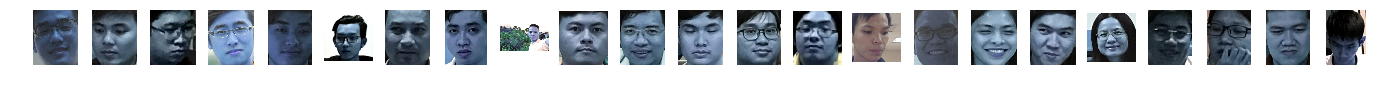

In [77]:
path = os.path.join(os.getcwd(), 'FaceDB/')
person_filenames = glob.glob(path+'*')
print('-  Số thư mục ảnh của học viên trong data set là %d người.'%len(person_filenames))
c = 0
empty_p =  []
d = {}
d_img = {}
for person in person_filenames:
  num_faces = glob.glob(person + '/*')
  if len(num_faces) == 0:
    c += 1
    empty_p.append(person.split('/')[-1])
  else:
    d[person.split('/')[-1]] = [len(num_faces)]
    d_img[person.split('/')[-1]] = num_faces[-1]
    
print('-  Số lượng thư mục không có ảnh là %d thư mục:'%c)
for i, p in enumerate(empty_p):
  print('\t%d.%s'%(i+1, p))

print('-  Số lượng thư mục có ảnh là %d thư mục.'%(len(person_filenames)-c))
print('\tBảng thống kê với mỗi người thì có bao nhiêu ảnh trong thư mục và hiển thị 1 ảnh đại diện tương ứng:')
df = pd.DataFrame.from_dict(d)
display(df)
col = df.columns

columns = len(person_filenames)-c
rows = 1
fig = plt.figure(figsize = (24,1))
plt.axis('off')
for i in range(columns):
    fig.add_subplot(rows,columns, i+1)
    temp = cv2.imread(d_img[col[i]])
    #print(temp)
    plt.imshow(temp)
    plt.axis('off')
plt.show()

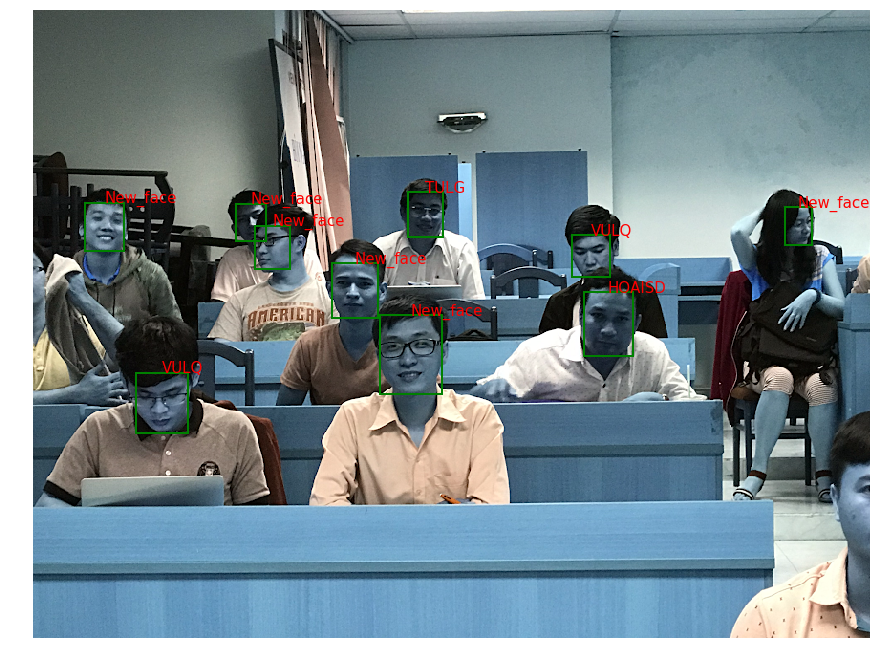

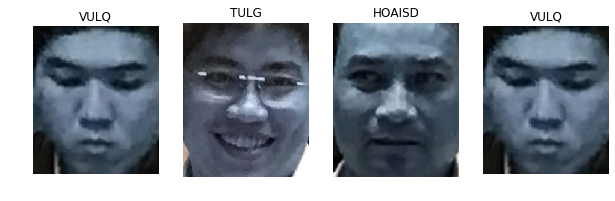

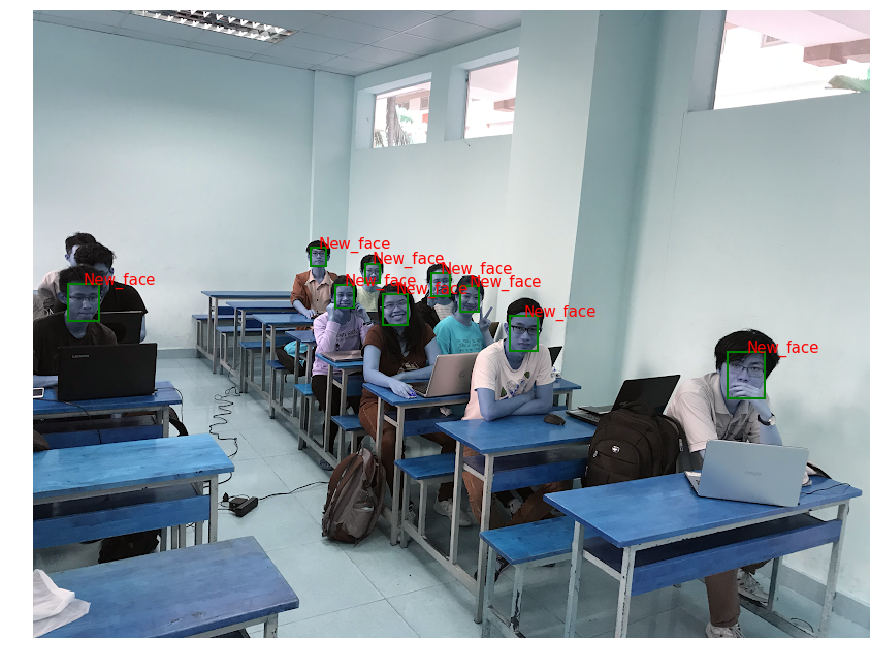

<Figure size 936x720 with 0 Axes>

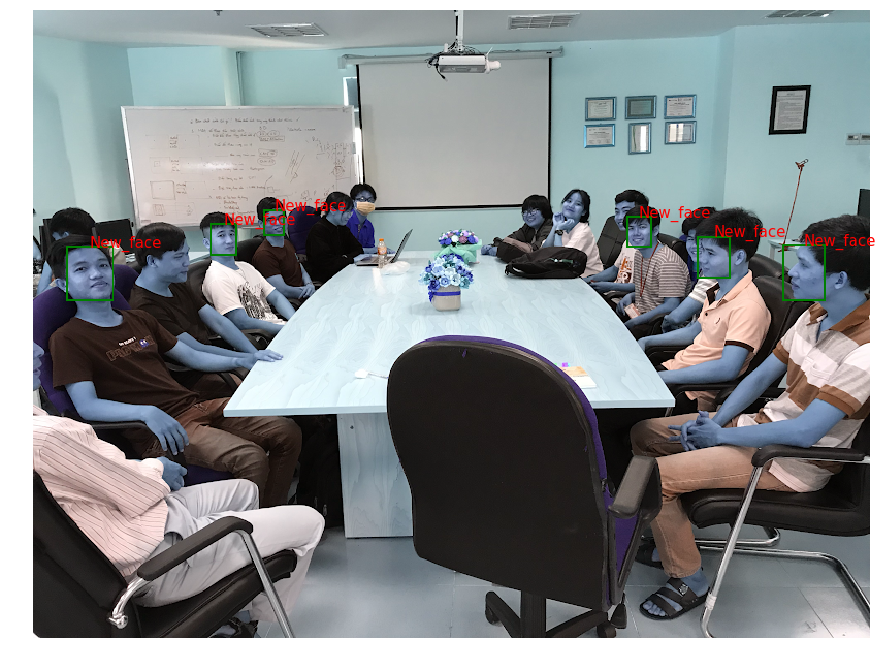

<Figure size 936x720 with 0 Axes>

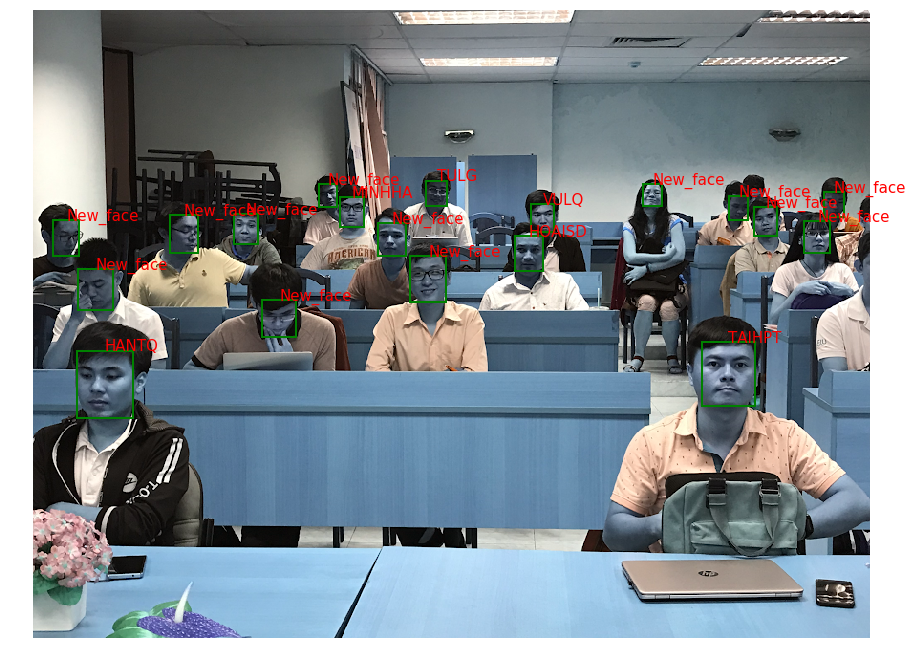

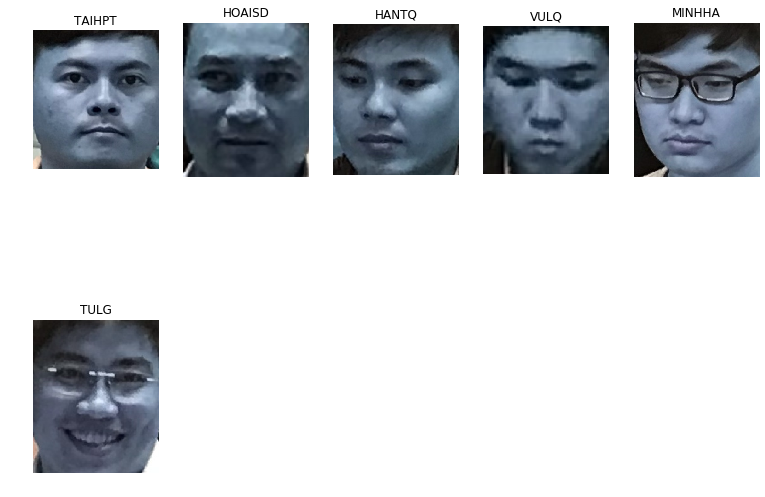

In [75]:
 # Thực hiện nhận dạng gương mặt trong ảnh test
# Hiển thị ảnh test với boundinh box của gương mặt và ID gương mặt
# Hiển thị các gương mặt trong dataset được nhận dạng trong ảnh test
for image in test_images:
  faceID_RC = test_face(image, face_known_filenames)
  faceID_show(faceID_RC)

#3.2.3 - Đánh giá kết quả: 4 ảnh test

###3.2.3 - a - Tóm tắt kết quả:
>> Ảnh 1: Ảnh lớp học, nhận diện được 50%

>> Ảnh 2: Ảnh lớp học khác (không có trong dataset), nhận diện được 81%

>> Ảnh 3: Ảnh lớp học khác (không có trong dataset), nhận diện được 46%

>> Ảnh 4: ảnh lớp học, nhận diện được 64%

####Trung bình 4 ảnh: 60,25%
###3.2.3 - b - Chi tiết đánh giá:
####Ảnh 1: Ảnh lớp học, nhận diện được 50%
>>>Số người trong ảnh: 12 người

>>>Số gương mặt bị che khuất: 2

>>>Số gương mặt detect được: 10

>>>Nhận diện gương mặt:
>>>>Ground Truth
>>>>>3 new_face

>>>>>2 người che nửa mặt: QUANVM, TAIHPT

>>>>>7 người được nhận diện: HOBV, VUND, MINHHA, TULG, VULQ, HOAISD, TIENBDT

>>>>Predict:
>>>>>6/12 = 0.5: nhận diện được 3 new_face, và nhận diện đúng 3 người trong ảnh

>>>>> 4/12 = 0.33:  nhận diện sai tên 1 người trong ảnh, và nhận diện sai 3 người thành new_face

>>>>>2/12 = 0.17: gương mặt không detect được

####Ảnh 2: Ảnh lớp học khác (không có trong dataset), 81%
>>>Số người trong ảnh: 11 người

>>>Số gương mặt bị che khuất: 2

>>>Số gương mặt detect được: 9

>>>Nhận diện gương mặt:
>>>>Ground Truth
>>>>>9 new_face

>>>>>2 người bị che khuất

>>>>Predict:
>>>>> 9/11 = 0.81: nhận diện được 9 new_face

>>>>>2/11 = 0.19 : gương mặt không detect được

####Ảnh 3: Ảnh lớp học khác (không có trong dataset), 46%
>>>Số người trong ảnh: 13 người

>>>Số gương mặt bị che khuất: 2 che khuất, 1 xoay ngang, 1 mang khẩu trang\
>>>Số gương mặt detect được: 9
>>>Nhận diện gương mặt:
>>>>Ground Truth
>>>>>10 new_face

>>>>>1 mang khẩu trang, 2 người che khuất nhiều

>>>>Predict:
>>>>> 6/13 = 0.46: nhận diện được 6 new_face

>>>>>7/13 = 0.54 : gương mặt không detect được

####Ảnh 4: ảnh lớp học, 64%
>>>Số người trong ảnh: 22 người

>>>Số gương mặt bị che khuất: 3

>>>Số gương mặt detect được: 19

>>>Nhận diện gương mặt:
>>>>Ground Truth
>>>>>8 new_face

>>>>>3 người che nửa mặt: DUYNN, 2 gương mặt không nhận diện được

>>>>>11 người được nhận diện: HANQT, TAIHPT, DUYETLV, QUANVM, HOBV, VUND, MINHHA, TULG, VULQ, HOAISD, TIENBDT

>>>>Predict:
>>>>> (6+8)/22 = 0.64: nhận diện được 8 new_face, và 6 người đúng

>>>>> 5/22 = 0.22: nhận diện sai 5 người thành new_face

>>>>> 3/22 = 0.14: gương mặt không detect được